In [4]:
import numpy as np
import h5py
import scipy as sp
import matplotlib.pyplot as plt
import os
from utils.opt_utils import *

In [5]:
# save_dir = r'C:\Users\Wang_Lab\Documents\GitLab\quantum_control_rl_server\examples\ctrl_vqe_pi_pulse_sim_entangle_interp\save_data'
# file_name = r'g11-n0-20241129-233021.h5'
save_dir = r'C:\Users\Wang_Lab\Documents\GitLab\quantum_control_rl_server\examples\exp_1g_interp_amp\save_data'
file_name = r'50pts-20250511-175329.h5'
# save_dir = r'C:\Users\Wang_Lab\Documents\GitLab\quantum_control_rl_server\examples\ctrl_vqe_state_prep_1g_interp\save_data'
# file_name = r'20241128-035501.h5'
file_path = os.path.join(save_dir, file_name)

In [6]:
hdf5_index = 0
start = -1
norm = 1

us = 0.000001
time_start = 0 * us
time_stop = 1.0 * us

N_opt_pts = 200

eval_rewards = []
eval_act_times = []
eval_act_amps = []
training_rewards = []
train_act_times = []
train_act_amps = []
with h5py.File(file_path, "r") as f:
    eval_rewards = f[str(hdf5_index)]["evaluation"]["rewards"][()]
    for key in list(f[str(hdf5_index)]["evaluation"]["actions"].keys()):
        key_first_word = key.split("_")[0]
        if key_first_word == "time":
            eval_act_times.append(f[str(hdf5_index)]["evaluation"]["actions"][key][()])
        if key_first_word == "pulse":
            eval_act_amps.append(f[str(hdf5_index)]["evaluation"]["actions"][key][()])
    for key in list(f[str(hdf5_index)]["training"]["actions"].keys()):
        key_first_word = key.split("_")[0]
        if key_first_word == "time":
            train_act_times.append(f[str(hdf5_index)]["training"]["actions"][key][()])
        if key_first_word == "pulse":
            train_act_amps.append(f[str(hdf5_index)]["training"]["actions"][key][()])
    training_rewards = f[str(hdf5_index)]["training"]["rewards"][()]

eval_rewards = (np.array(eval_rewards).T)[0]
eval_act_times = np.array(eval_act_times)
eval_act_amps = np.array(eval_act_amps)
training_rewards = np.array(training_rewards)
train_act_times = np.array(train_act_times)
train_act_amps = np.array(train_act_amps)

## Evaluation infidelity

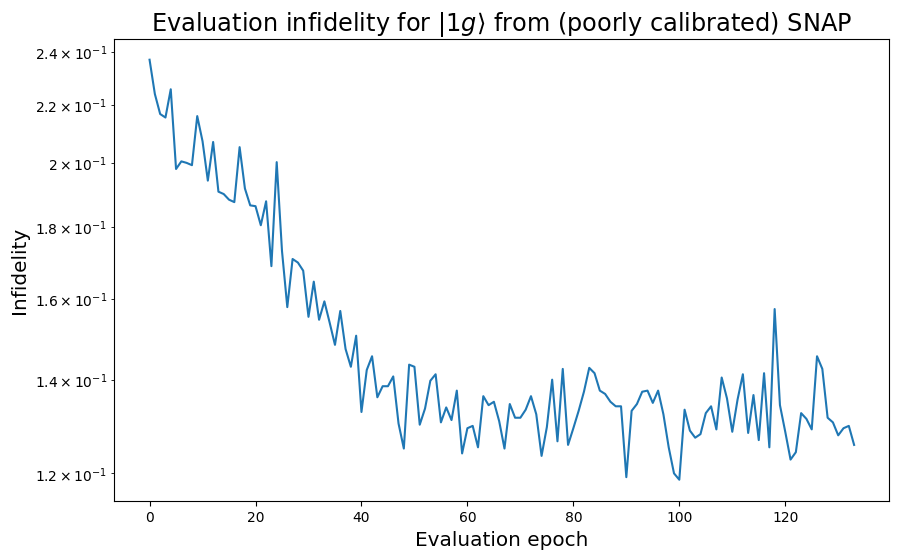

In [7]:
x_pts = np.arange(0, len(eval_rewards))

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(x_pts, (norm - eval_rewards) / (norm - start))
plt.xlabel("Evaluation epoch", size="x-large")
plt.ylabel("Infidelity", size="x-large")
plt.title(r"Evaluation infidelity for $|1g\rangle$ from (poorly calibrated) SNAP", size="xx-large")
plt.yscale("log")
plt.show()

## Training infidelity

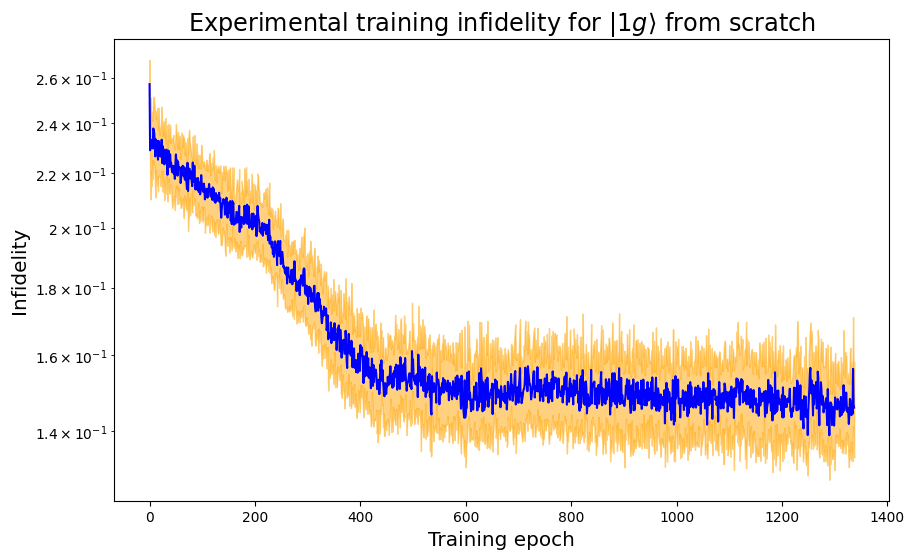

In [8]:
x_pts = np.arange(0, len(training_rewards))
training_reward_avgs = np.average(training_rewards, axis=1)
training_reward_stds = np.std(training_rewards, axis=1)

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(x_pts, (norm - training_reward_avgs) / (norm - start), color="blue")
plt.fill_between(x_pts, (norm - training_reward_avgs - training_reward_stds) / (norm - start), (norm - training_reward_avgs + training_reward_stds) / (norm - start), color="orange", alpha=0.5)
plt.xlabel("Training epoch", size="x-large")
plt.ylabel("Infidelity", size="x-large")
# plt.title(r"Training infidelity for $\frac{|0\rangle + |1\rangle}{\sqrt{2}} \otimes \frac{|g\rangle + |e\rangle}{\sqrt{2}} \rightarrow \frac{|0g\rangle + |1e\rangle}{2}$", size="xx-large")
plt.title(r"Experimental training infidelity for $|1g\rangle$ from scratch", size="xx-large")
plt.yscale("log")
plt.show()

## Some data processing

In [9]:
# times = np.transpose(eval_act_times, axes=(1, 0, 2))
amps = np.transpose(eval_act_amps, axes=(1, 0, 2))

times_arr = np.linspace(time_start, time_stop, N_opt_pts + 2)
times_arr = times_arr[1:-1]
timesarr_2 = np.array([times_arr, times_arr, times_arr, times_arr])
times = []
for i in range(np.shape(amps)[0]):
    times.append(timesarr_2)

times_shape = np.shape(times)
amps_shape = np.shape(amps)

times_buf = np.empty((times_shape[0], times_shape[1], times_shape[2] + 2))
amps_buf = np.empty((amps_shape[0], amps_shape[1], amps_shape[2] + 2))

num_evals = times_shape[0]
num_drive_terms = times_shape[1]
num_points = times_shape[2] + 2

print(f'num_drive_terms: {num_drive_terms}')
print(f'num_points: {num_points}')

start_buffer_arr = time_start * np.ones((num_drive_terms, 1), dtype=np.float32)
stop_buffer_arr = time_stop * np.ones((num_drive_terms, 1), dtype=np.float32)

for i in range(np.shape(amps)[0]):
    reorder = (times[i]).argsort()
    
    for j in range(np.shape(amps)[1]):
        amps[i][j] = amps[i][j][reorder[j]]
        times[i][j] = times[i][j][reorder[j]]
    
    times_buf[i] = np.append(np.append(start_buffer_arr, times[i], axis=1), stop_buffer_arr, axis=1)
    
    amps_buf[i] = interp_amp_wrapper(amps[i])
    


num_drive_terms: 4
num_points: 202


## All waveforms

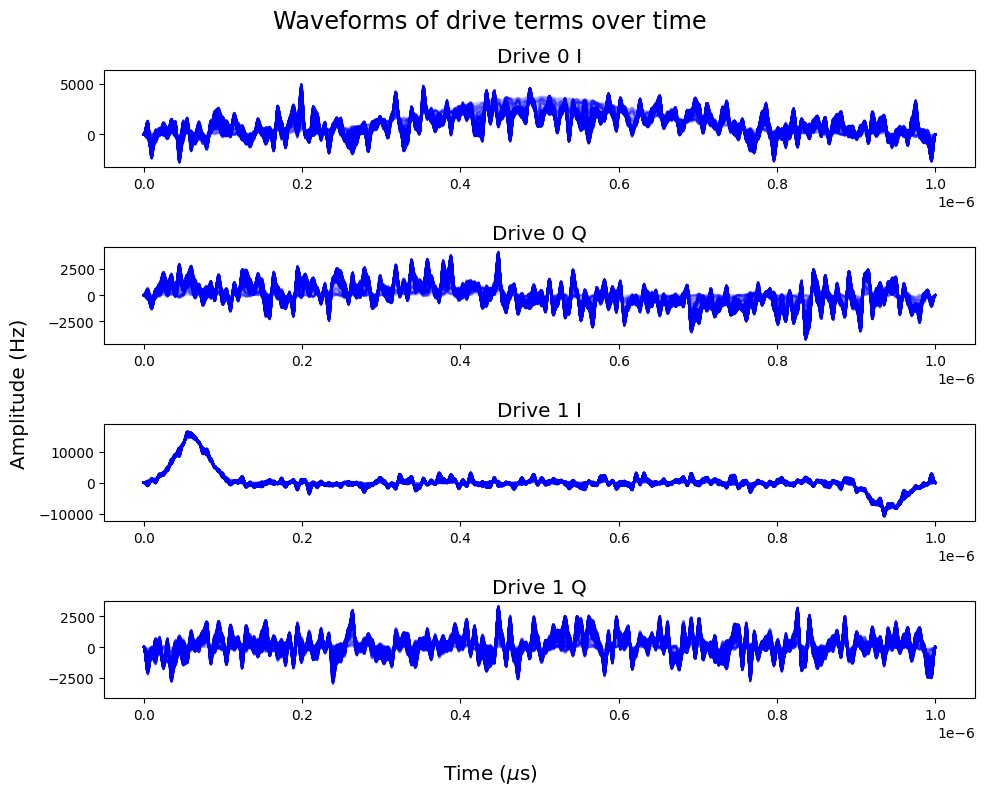

In [10]:
iter = 0
npts = 1001
t_pts = np.linspace(time_start, time_stop, npts)

fig, ax = plt.subplots(times_shape[1], 1)
fig.set_size_inches(10, 8)

all_comp_amp_funcs = []

for i in range(num_evals):
    times_temp = times_buf[i]
    amps_temp = amps_buf[i]
        
    drive_amp_funcs = [
        [interp_seg(amps_temp[j][k:k+2], times_temp[j][k:k+2]) for k in range(len(times_temp[j]) - 1)] for j
        in range(num_drive_terms)]

    comp_amp_funcs = [func_sum(np.array(drive_amp_funcs[j])) for j in range(num_drive_terms)]
    all_comp_amp_funcs.append(comp_amp_funcs)
    
    for j in range(num_drive_terms):
        ax[j].plot(t_pts, comp_amp_funcs[j](t_pts), alpha=(i + 1) / num_evals, color="blue")
        
for i in range(int(num_drive_terms / 2)):
    ax[int(2 * i)].set_title(f'Drive {i} I', size="x-large")
    ax[int((2 * i) + 1)].set_title(f'Drive {i} Q', size="x-large")
fig.supxlabel(r'Time ($\mu$s)', size="x-large")
fig.supylabel("Amplitude (Hz)", size="x-large")
fig.suptitle("Waveforms of drive terms over time", size="xx-large")
fig.tight_layout()
plt.show()

In [11]:
def plot_waveforms(times, amps, wf_indices, title=None):
    times_shape = np.shape(times_buf)
        
    num_evals = times_shape[0]
    num_drive_terms = times_shape[1]
    
    fig, ax = plt.subplots(num_drive_terms, 1)
    fig.set_size_inches(10, 8)
    
    for i, wf_i in enumerate(wf_indices):
        times_temp = times[wf_i]
        amps_temp = amps[wf_i]
        
        drive_amp_funcs = [
            [interp_seg(amps_temp[j][k:k+2], times_temp[j][k:k+2]) for k in range(len(times_temp[j]) - 1)] for j
            in range(num_drive_terms)]
    
        comp_amp_funcs = [func_sum(np.array(drive_amp_funcs[j])) for j in range(num_drive_terms)]
        all_comp_amp_funcs.append(comp_amp_funcs)
        
        for j in range(num_drive_terms):
            if i == 0:
                ax[j].plot(t_pts, comp_amp_funcs[j](t_pts), alpha=(i + 1) / len(wf_indices), color="blue", label="Initial waveform")
            elif i == len(wf_indices) - 1:
                ax[j].plot(t_pts, comp_amp_funcs[j](t_pts), alpha=(i + 1) / len(wf_indices), color="blue", label="Final waveform")
            else:
                ax[j].plot(t_pts, comp_amp_funcs[j](t_pts), alpha=(i + 1) / len(wf_indices), color="blue")
    
    for i in range(int(num_drive_terms / 2)):
        ax[int(2 * i)].set_title(f'Drive {i} I', size="x-large")
        ax[int((2 * i) + 1)].set_title(f'Drive {i} Q', size="x-large")
    fig.supxlabel(r'Time ($\mu$s)', size="x-large")
    fig.supylabel("Amplitude (Hz)", size="x-large")
    if title is None:
        fig.suptitle("Waveforms of drive terms over time", size="xx-large")
    else:
        fig.suptitle(title, size="xx-large")
    fig.tight_layout()
    
    return fig, ax

In [12]:
img_save_dir = r'C:\Users\Wang_Lab\Desktop\photos'
img_name = r'temp.png'
img_save_path = os.path.join(img_save_dir, img_name)
# \frac{|0\rangle + |1\rangle}{\sqrt{2}} \otimes \frac{|g\rangle + |e\rangle}{\sqrt{2}} \rightarrow \frac{|0g\rangle + |1e\rangle}{2}
plot_indices = [0, np.argmax(eval_rewards)]
print(np.shape(training_rewards))
train_max_index = np.argmax(training_rewards)
# plot_indices_2 = [0, np.argmax(training_rewards)]
pi0 = round(np.floor(train_max_index / 20))
pi1 = train_max_index % 20

init_train_times = train_act_times # [:, 0, 0, :]
init_train_amps = train_act_amps[:, 0, 0, :]

# opt_train_times = train_act_times[:, pi0, pi1, :]
opt_train_amps = train_act_amps[:, pi0, pi1, :]

init_train_times = [t_pts, t_pts]
opt_train_times = [t_pts, t_pts]

print(f'init_train_times: {init_train_times}')
print(f'opt_train_times: {opt_train_times}')
print(np.shape(t_pts))

plot_train_times = np.array([init_train_times, opt_train_times])
plot_train_amps = np.array([init_train_amps, opt_train_amps])

reorder = (plot_train_times).argsort()

print(np.shape(plot_train_amps))
print(np.shape(plot_train_amps)[0])

plot_train_times_shape = np.shape(plot_train_times)
plot_train_amps_shape = np.shape(amps)

print(f'train times shape: {plot_train_times_shape}')
print(f'train amps shape: {plot_train_amps_shape}')

plot_train_times_buf = np.empty((plot_train_times_shape[0], plot_train_times_shape[1], plot_train_times_shape[2] + 2))
plot_train_amps_buf = np.empty((plot_train_amps_shape[0], plot_train_amps_shape[1], plot_train_amps_shape[2] + 2))

for i in range(np.shape(plot_train_amps)[0]):
    reorder = (plot_train_times[i]).argsort()
    
    for j in range(np.shape(plot_train_amps)[1]):
        plot_train_amps[i][j] = plot_train_amps[i][j][reorder[j]]
        plot_train_times[i][j] = plot_train_times[i][j][reorder[j]]
    
    plot_train_times_buf[i] = np.append(np.append(start_buffer_arr, plot_train_times[i], axis=1), stop_buffer_arr, axis=1)
    
    plot_train_amps_buf[i] = interp_amp_wrapper(plot_train_amps[i])

print(f'np.shape(plot_train_times_buf): {np.shape(plot_train_times_buf)}')
print(f'np.shape(plot_train_amps_buf): {np.shape(plot_train_amps_buf)}')

init_fidelity = 1 - ((norm - training_rewards[0, 0]) / (norm - start))
opt_fidelity = 1 - ((norm - training_rewards[pi0, pi1]) / (norm - start))
print(times_buf)
fix, ax = plot_waveforms(plot_train_times_buf, plot_train_amps_buf, [0, 1], title=r'Waveforms of drive terms,' + f' Fidelity = {init_fidelity:.4f} ' + r'$\rightarrow$' + f' {opt_fidelity:.4f}')
ax[0].legend(loc="upper right")
plt.savefig(img_save_path)
plt.show()

(1338, 20)
init_train_times: [array([0.00e+00, 1.00e-09, 2.00e-09, ..., 9.98e-07, 9.99e-07, 1.00e-06]), array([0.00e+00, 1.00e-09, 2.00e-09, ..., 9.98e-07, 9.99e-07, 1.00e-06])]
opt_train_times: [array([0.00e+00, 1.00e-09, 2.00e-09, ..., 9.98e-07, 9.99e-07, 1.00e-06]), array([0.00e+00, 1.00e-09, 2.00e-09, ..., 9.98e-07, 9.99e-07, 1.00e-06])]
(1001,)
(2, 4, 200)
2
train times shape: (2, 2, 1001)
train amps shape: (134, 4, 200)


IndexError: index 200 is out of bounds for axis 0 with size 200

1e-06


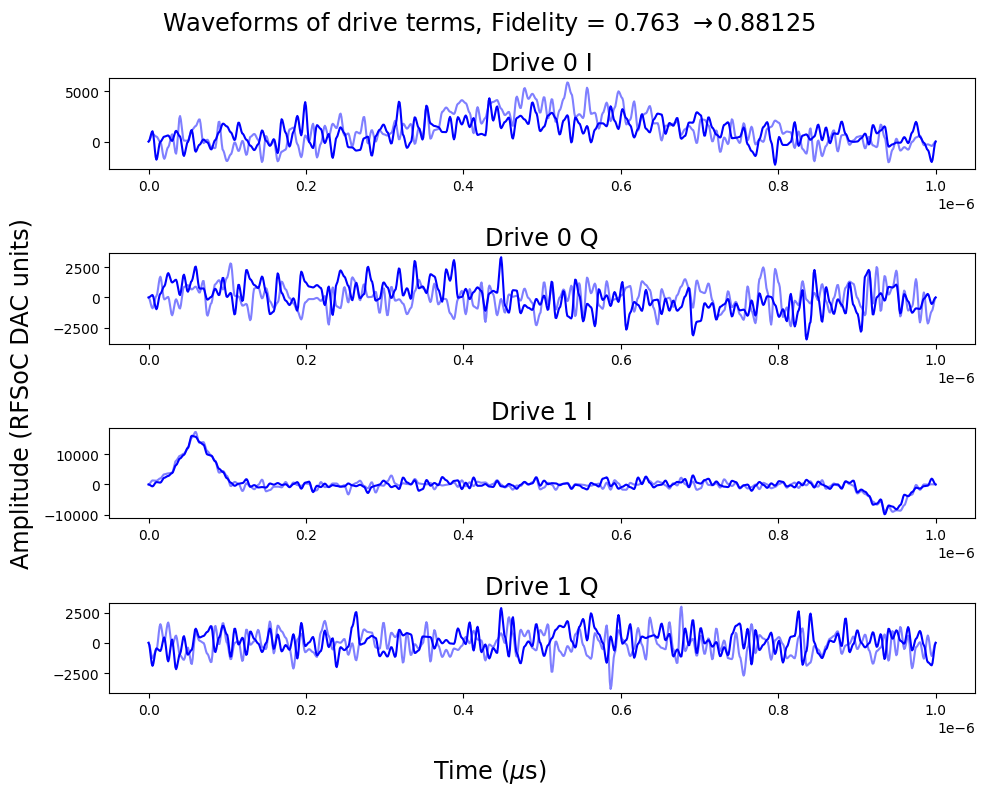

In [13]:
iter = 0
npts = 1001
t_pts = np.linspace(time_start, time_stop, npts)

print(time_stop)

fig, ax = plt.subplots(times_shape[1], 1)
fig.set_size_inches(10, 8)

all_comp_amp_funcs = []

for k, i in enumerate([0, np.argmax(eval_rewards)]):
    times_temp = times_buf[i]
    amps_temp = amps_buf[i]
        
    drive_amp_funcs = [
        [interp_seg(amps_temp[j][k:k+2], times_temp[j][k:k+2]) for k in range(len(times_temp[j]) - 1)] for j
        in range(num_drive_terms)]

    comp_amp_funcs = [func_sum(np.array(drive_amp_funcs[j])) for j in range(num_drive_terms)]
    all_comp_amp_funcs.append(comp_amp_funcs)
    
    for j in range(num_drive_terms):
        ax[j].plot(t_pts, comp_amp_funcs[j](t_pts), alpha=(k + 1) / 2, color="blue")
        
for i in range(int(num_drive_terms / 2)):
    ax[int(2 * i)].set_title(f'Drive {i} I', size="xx-large")
    ax[int((2 * i) + 1)].set_title(f'Drive {i} Q', size="xx-large")
fig.supxlabel(r'Time ($\mu$s)', size="xx-large")
fig.supylabel("Amplitude (RFSoC DAC units)", size="xx-large")
fig.suptitle(f'Waveforms of drive terms, Fidelity = {1 - round((norm - eval_rewards[0]) / (norm - start), 5)} ' + r'$\rightarrow$' + f'{1 - round((norm - max(eval_rewards)) / (norm - start), 5)} ', size="xx-large")
fig.tight_layout()
plt.show()

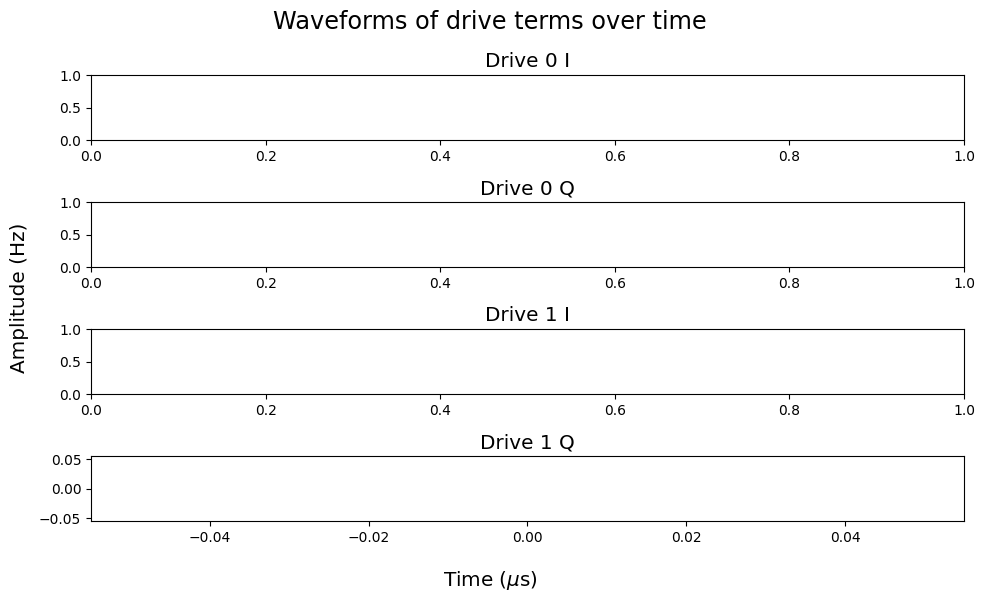

In [77]:
best_eval_reward = np.argmax(eval_rewards)

fig, ax = plt.subplots(num_drive_terms, 1)

for i in range(num_drive_terms):
    plt.plot()
    
for i in range(int(num_drive_terms / 2)):
    ax[int(2 * i)].set_title(f'Drive {i} I', size="x-large")
    ax[int((2 * i) + 1)].set_title(f'Drive {i} Q', size="x-large")
fig.supxlabel(r'Time ($\mu$s)', size="x-large")
fig.supylabel("Amplitude (Hz)", size="x-large")
fig.suptitle("Waveforms of drive terms over time", size="xx-large")
fig.tight_layout()
plt.show()

In [78]:
times = eval_act_times
amps = eval_act_amps

ti = times[0][0]
tf = times[0][-1]
npts = 1001
t_pts = np.linspace(ti, tf, npts)

drive_amp_funcs = [
        [rect_seg(amps[j][i], times[j][i], times[j][i + 1]) for i in range(len(times[j]) - 1)] for j
        in range(len(times))]
comp_amp_funcs = [func_sum(np.array(drive_amp_funcs[i])) for i in range(len(drive_amp_funcs))]

print(type(comp_amp_funcs[0]))

for i in range(len(times)):
    plt.plot(t_pts, (comp_amp_funcs[i])(t_pts), label=f'Waveform {i}')
    plt.legend()
    plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# eval_act_times
# eval_act_amps

for i in range(len(eval_act_times[0])):
    for j in eval_act_times

In [ ]:
with h5py.File(os.path.join(save_dir, hdf5_name), "r") as f:
        opt_res_index = np.argmax(f[str(i + hdf5_ _index)]["evaluation"]["rewards"][()])
        opt_result = f[str(i + hdf5_start_index)]["evaluation"]["rewards"][()][opt_res_index]
        for j in range(2 * num_drives):
            opt_amps.append([f[str(i + hdf5_start_index)]["evaluation"]["actions"][f'pulse_array_{j}'][()][opt_res_index]])
        for j in range(2 * num_drives):
            opt_times.append([f[str(i + hdf5_start_index)]["evaluation"]["actions"][f'time_array_{j}'][()][opt_res_index]])
        for j in range(num_drives):
            opt_freqs.append(f[str(i + hdf5_start_index)]["evaluation"]["actions"][f'freq_{j}'][()][opt_res_index])